# Machine learning engineer  - тестовое задание, 2024 от MAINS LAB

**Формулировка задачи:**

Доступны данные о количестве обращений за медицинской помощью по 50 000 застрахованным ДМС за 2022 год. Требуется на основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год. 

Доступны 2 выборки: 

- train - выборка для обучения и валидации , 50 тыс. застрахованных с проставленными значениями target.
- holdout - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения target скрыты.

Для оценки качества модели будет применяться метрика MSE.

Данные можно скачать по [ссылке](https://disk.yandex.ru/d/en-7B7zehuZAsQ)


 **Ход исследования:**

Иследование будет включать в себя следующие шаги:
   - Загрузка и подготовка данных
   - Исследовательский анализ данных
   - Предобработка данных
       - Выводы
   - Обучение разных моделей на кросс-валидации и подбор гиперпараметров
       - Baseline модель для сравнения
       - Подбор гимерпараметров моделей 
       - Отбор модели регрессии и с наименьшим значением MSE
       - Выводы
   - Проведение финального тестирования и формирование результата на тестовой выборке
       - Проверка MSE на тестовой выборке
   - Общий вывод
   - Отчет по решению


**Описание данных:**

- `Insured_PIN` - уникальный ид застрахованного лица
- `Insured_Network` - Идентификатор сети клиник доступной для застрахованного. `Network - 1` - клиники с наивысшим уровнем сервиса, `Network - 8` - клиники с самым базовым уровнем сервиса.
- `Nationality` - национальность застрахованного.
- `Gender` - пол застрахованного
- `Relation` - в качестве кого застраховано данное лицо. `self` - работник организации, которая оформляет страховку, `child` - ребенок застрахованного и т.д.
- `DoB` - дата рождения застрахованного
- `Diagnoses` - все диагнозы застрахованного за 2022 год
- `HasChronicDisease` - флаг хронического пациента
- `Exposition_22` - количество дней в 2022 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год
- `number_of_visits_22` - количество дней в 2022 году в которые застрахованный посещал клинику для получения медицинской помощи
- `number_of_services_22` - количество оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.)
- `Exposition_23` - количество дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год
- **Target -** `number_of_visits_23` - количество дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи. **Этот показатель требуется предсказать.**


## Загрузка и подготовка данных 

In [1]:
import gc
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.experimental import enable_halving_search_cv

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, ParameterSampler, GridSearchCV, HalvingGridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   PolynomialFeatures,
                                   SplineTransformer,
                                   FunctionTransformer)
                                  
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from lightgbm import LGBMRegressor, plot_importance
from urllib import request

In [2]:
def downcast_df(df):
    '''Оптимизирует занимаемую датафреймом память по числовому типу'''
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
    return df

Определение глобальных переменных:

In [3]:
dataset_path = '/home/panther/Documents/Deep Learning/datasets/'
tar_col = 'number_of_visits_23'
cat_cols = ['Insured_Network', 'Nationality', 'Gender', 'Relation','HasChronicDisease']
num_cols = ['Exposition_22', 'number_of_visits_22',
            'number_of_services_22', 'Exposition_23']
random_state = 42

### Загрузка данных

Загрузка классификатора болезней:

In [4]:
# url = 'https://mkb10.su/download/mkb10.xlsx'
# user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
# headers = {'User-Agent': user_agent}
# req = request.Request(url, headers=headers)

# with request.urlopen(req) as inp_file:
#     with open(dataset_path+'mkb10.xlsx', 'wb') as outp_file:
#             outp_file.write(inp_file.read())

In [5]:
mkb10  = pd.read_excel(dataset_path+'mkb10.xlsx', skiprows=range(3)).set_index('Код диагноза')

Загрузка выборок с данными проекта:

In [6]:
train = downcast_df(pd.read_excel(dataset_path + 'ML_train.xlsx'))
test = downcast_df(pd.read_excel(dataset_path + 'ML_holdout.xlsx'))

In [7]:
print(f'размерность обучающей выборки: {train.shape}')
print(f'размерность тестовой выборки: {test.shape}')

размерность обучающей выборки: (50000, 13)
размерность тестовой выборки: (10000, 12)


### Исследовательский анализ

#### Обзор данных

In [8]:
mkb10.head()

,Название диагноза,Код родителя
Код диагноза,,
A00-B99,Некоторые инфекционные и паразитарные болезни,NaN
A00-A09,Кишечные инфекции,A00-B99
A00,Холера,A00-A09
A00.0,"Холера, вызванная холерным вибрионом 01, биова...",A00
A00.1,"Холера, вызванная холерным вибрионом 01, биова...",A00


In [9]:
train.head()

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
0,1006786,Network-4,Group 2,Male,Self,1974-04-28,NaN,0,365,0,0,365,0
1,1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365,4
2,1019055,Network-5,Group 2,Male,Self,1979-02-20,J03.9,0,365,1,4,365,5
3,1019438,Network-1,Saudi,Male,Self,1985-05-09,E56.9;J02;J00,1,365,3,18,365,11
4,1027311,Network-3,Group 3,Male,Self,1962-01-01,NaN,0,365,0,0,365,0


In [10]:
test.head()

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
0,1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365
1,22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365
2,1518945,Network-2,Saudi,Female,Spouse,1962-11-28,D64.9;J06;H04.1;M13.9,0,365,5,11,365
3,1344077,Network-2,Saudi,Male,Child,2003-07-09,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365
4,1354276,Network-2,Saudi,Female,Spouse,1995-07-22,UNKRC;N64;A09,0,365,3,10,365


In [11]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            50000 non-null  int32         
 1   Insured_Network        50000 non-null  object        
 2   Nationality            50000 non-null  object        
 3   Gender                 50000 non-null  object        
 4   Relation               50000 non-null  object        
 5   DoB                    49999 non-null  datetime64[ns]
 6   Diagnoses              41226 non-null  object        
 7   HasChronicDisease      50000 non-null  int8          
 8   Exposition_22          50000 non-null  int16         
 9   number_of_visits_22    50000 non-null  int16         
 10  number_of_services_22  50000 non-null  int16         
 11  Exposition_23          50000 non-null  int16         
 12  number_of_visits_23    50000 non-null  int16         
dtypes

In [12]:
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            10000 non-null  int32         
 1   Insured_Network        10000 non-null  object        
 2   Nationality            10000 non-null  object        
 3   Gender                 10000 non-null  object        
 4   Relation               10000 non-null  object        
 5   DoB                    10000 non-null  datetime64[ns]
 6   Diagnoses              8274 non-null   object        
 7   HasChronicDisease      10000 non-null  int8          
 8   Exposition_22          10000 non-null  int16         
 9   number_of_visits_22    10000 non-null  int8          
 10  number_of_services_22  10000 non-null  int16         
 11  Exposition_23          10000 non-null  int16         
dtypes: datetime64[ns](1), int16(3), int32(1), int8(2), object(5)


Пропуски в колонках признаков `Diagnoses` и `DoB` 

In [13]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
Insured_PIN,50000.0,5105306.52908,7491.0,1394019.75,1456638.0,1560591.0,91005334.0,14439779.732089
DoB,49999,1990-02-22 19:50:30.036600704,1920-03-21 00:00:00,1971-03-23 00:00:00,1991-11-13 00:00:00,2011-04-17 00:00:00,2022-11-12 00:00:00,NaN
HasChronicDisease,50000.0,0.33794,0.0,0.0,0.0,1.0,1.0,0.473013
Exposition_22,50000.0,358.89896,50.0,365.0,365.0,365.0,365.0,35.562003
number_of_visits_22,50000.0,5.74032,0.0,1.0,4.0,8.0,151.0,6.592556
number_of_services_22,50000.0,22.47742,0.0,3.0,13.0,31.0,962.0,29.714146
Exposition_23,50000.0,355.58842,50.0,365.0,365.0,365.0,365.0,43.779065
number_of_visits_23,50000.0,5.89886,0.0,1.0,4.0,8.0,202.0,6.856904


In [14]:
test.describe().T

,count,mean,min,25%,50%,75%,max,std
Insured_PIN,10000.0,5321900.0314,63665.0,1394638.0,1457448.0,1622644.75,91051569.0,14879404.910504
DoB,10000,1990-02-05 12:24:02.880000128,1922-02-13 00:00:00,1970-09-01 18:00:00,1991-11-09 12:00:00,2011-02-19 06:00:00,2022-11-12 00:00:00,NaN
HasChronicDisease,10000.0,0.338,0.0,0.0,0.0,1.0,1.0,0.473052
Exposition_22,10000.0,359.4261,50.0,365.0,365.0,365.0,365.0,33.756826
number_of_visits_22,10000.0,5.8236,0.0,1.0,4.0,8.0,113.0,6.789425
number_of_services_22,10000.0,22.9913,0.0,3.0,13.0,31.0,495.0,30.820412
Exposition_23,10000.0,355.0386,50.0,365.0,365.0,365.0,365.0,45.307745


Распределение числовых признаков обучающей выборки:

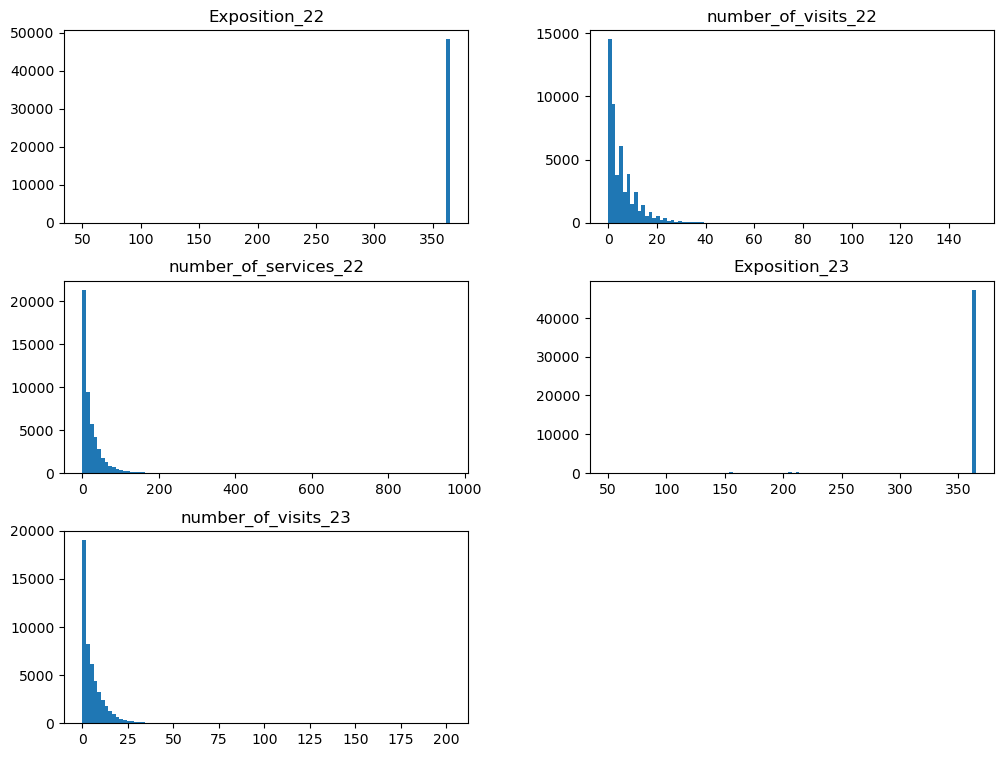

In [15]:
train[num_cols+[tar_col]].hist(bins=100, figsize=(12, 9), grid=False);

Распределения `Exposition_22` и `Exposition_23` выглядят, как смещенные выбросами в районе 365, но это не так из-за особенностей оформления страховых полисов, которые как правило оформляются на весь год. За исключением круглогодичных полисов, распределение сроков выглядит равномерным.

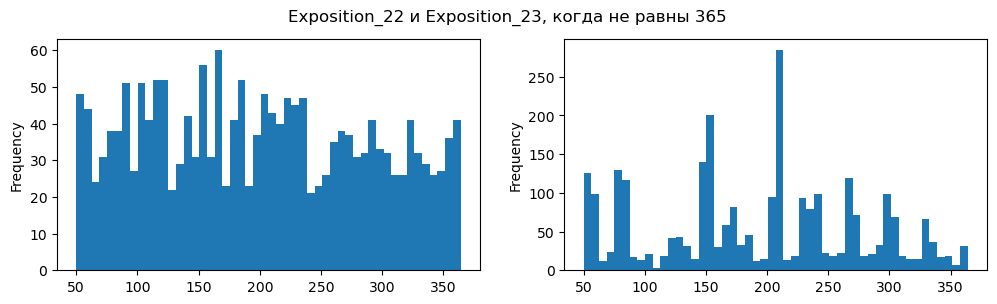

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 3))
fig.suptitle('Exposition_22 и Exposition_23, когда не равны 365')
axes = axes.flat
for i, col in enumerate(['Exposition_22', 'Exposition_23']):
    train.loc[train[col] != 365, col].plot.hist(ax=axes[i], bins=50, grid=False)

Распределение категориальных признаков обучающей выборки:

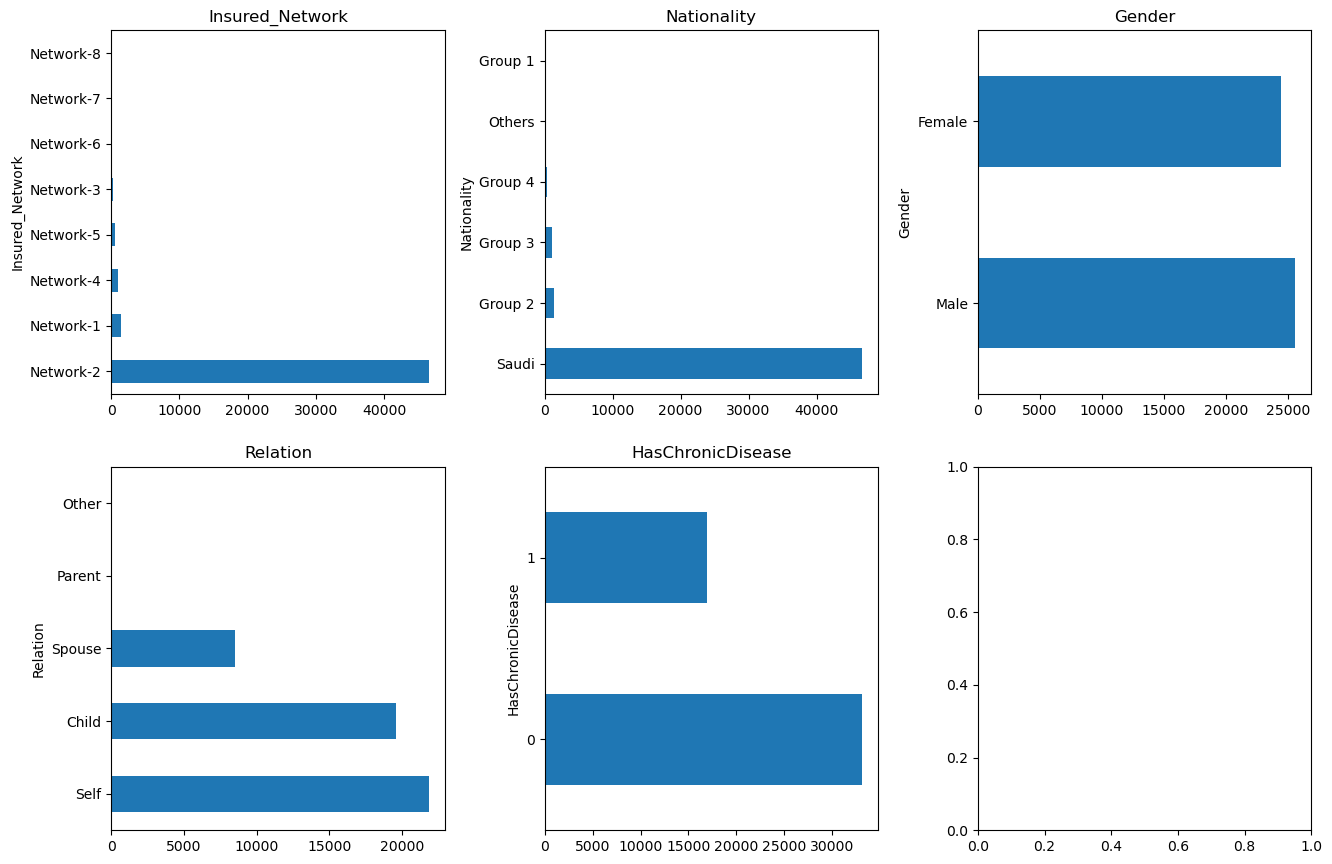

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flat
for i, col in enumerate(cat_cols):
    train[col].value_counts().plot.barh(ax=axes[i])
    axes[i].set_title(col)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.2)

- Самое распространенные страховые сети - сети с высоким, но не наивысшим уровнем обслуживания, в данных больше всего клиентов именно этих - страховых сетей с соотношением 9 к 1 ко всем остальным сетям.
- Преобладающая национальность - саудиты, также с соотношением 9 к 1 ко всем остальным
- Распределение полов - примерно одинаковое с небольшим преобладанием мужчин
- Больше всего страховок приобретено на себя, затем на ребенка, затем на жену
- Количество пациентов с хроническими болезнями примерно вдвое меньше количества пациентов без


100

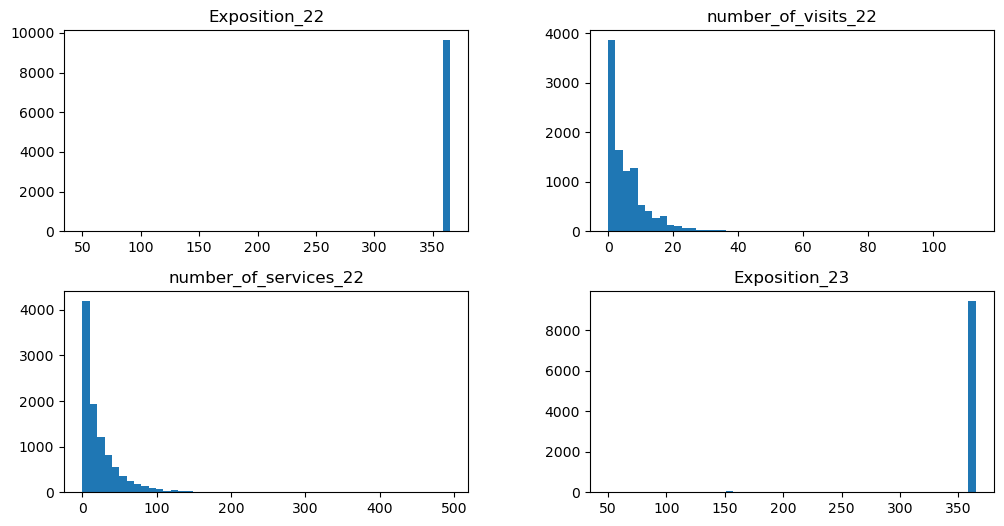

In [18]:
test[num_cols].hist(bins=50, figsize=(12, 6), grid=False);100

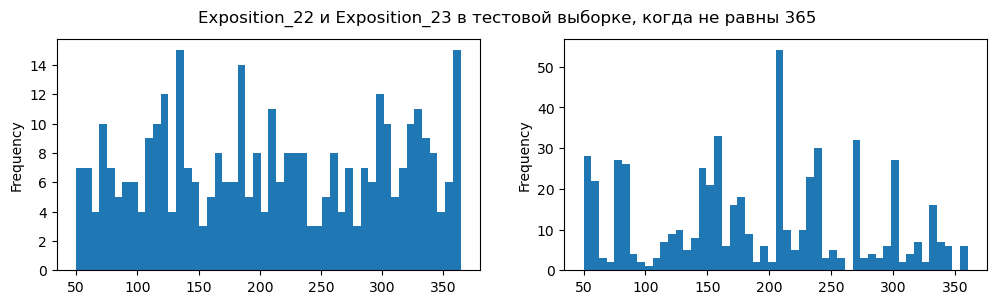

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 3))
fig.suptitle('Exposition_22 и Exposition_23 в тестовой выборке, когда не равны 365')
axes = axes.flat
for i, col in enumerate(['Exposition_22', 'Exposition_23']):
    test.loc[test[col] != 365, col].plot.hist(ax=axes[i], bins=50, grid=False)

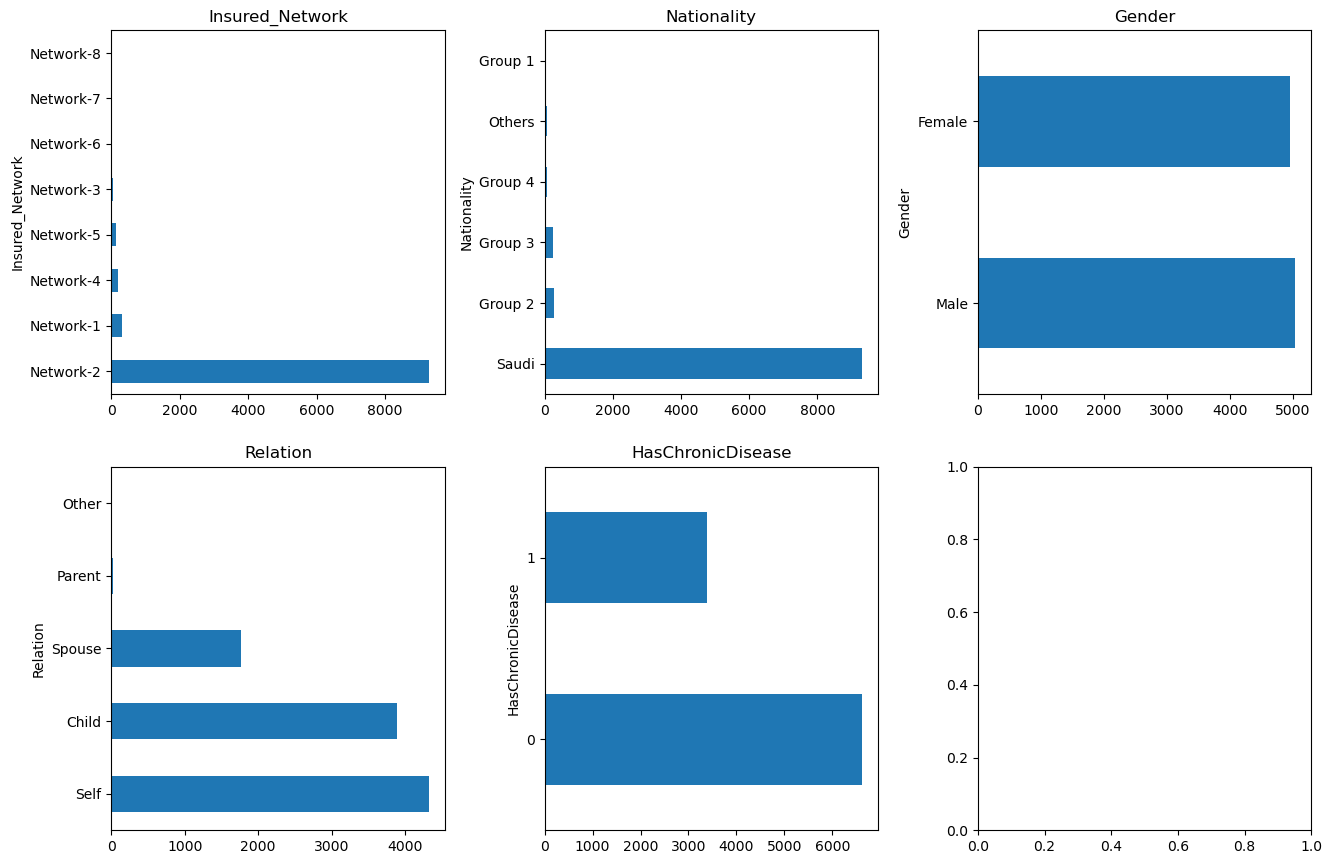

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flat
for i, col in enumerate(cat_cols):
    test[col].value_counts().plot.barh(ax=axes[i])
    axes[i].set_title(col)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.2)

Расределения тестовой выборки сходны с таковыми у обучающей

Проверка на дубликаты:

In [21]:
# на явные дубликаты
train.duplicated().sum()

0

In [22]:
test.duplicated().sum()

0

In [23]:
# на дубликаты клиентских идентификаторов
train['Insured_PIN'].duplicated().sum()

0

In [24]:
test['Insured_PIN'].duplicated().sum()

0

#### Предобработка данных и конструирование новых признаков

Определение функций:

In [25]:
def preprocess(df):
    '''Конструирование новых признаков и удаление лишних'''
    df['Age'] = ((pd.to_datetime('now')-df['DoB']).dt.days / 365.25).astype('float16') # перевожу даты рождения в числовой формат
    df = df.drop('DoB', axis=1)
    
    # Новые признаки:
    # 1) отношение сроков действия страховки год к году;
    # 2) абсолютная разница между сроками;
    # 3) среднее количество услуг за визит за год
    df['Exposition_rate'] = (df['Exposition_23'] / df['Exposition_22']).astype('float32')
    df['Exposition_abs_diff'] = df.apply(lambda x: np.abs(x['Exposition_23'] - x['Exposition_22']), axis=1).astype('int16')
    df['Services_per_visit_22'] = df['number_of_services_22'] / df['number_of_visits_22'].astype('float32').fillna(-1)
    return df

def sparsing_diags(df):
    '''Функция преобразования кодов диагнозов в матрицу и объединения с основным датафреймом'''
    # применение функции разделения дигнозов на разреженные списки, где индекс соответствует болезни,
    # а значение - конкретному диагнозу
    diags_inds, diags_lists = separate_diags_vec(df['Diagnoses'].dropna().index,
                                                 df['Diagnoses'].dropna().str.split(';').to_list())

    # преобразовние разреженных списков дигнозов в датафреймы
    diags_df = pd.DataFrame(index=diags_inds, data=np.stack(diags_lists), columns=diags_columns)
    
    # Объединение в общий датафрем
    df = pd.merge(df.drop('Diagnoses', axis=1), diags_df, left_index=True, right_index=True, how='outer').fillna(-1)
    df[diags_columns] = df[diags_columns].astype('int8')
    return df

def separate_diags(ind, diags):
    '''
    Функция разделяет коды состояний/болезней от кодов диагнозов, а также заполняет отсутствующие
    диагнозы при наличном в данных коде болезни на "9" - неуточненное состояние болезни
    вход: int, list - индекс строки датафрейма; список с болезнями.диагнозами пациента
    выход: int, list - индекс строки датафрейма; список с кодами диагнозов длины len(diags_columns), где индекс -
    - позиция состояния/болезни в списке
    '''
    diag_list = [-1]*diags_columns.shape[0]
    for diag in diags:
        a = re.split(r'\W+', diag)
        if len(a) == 1:
            diag_name = a[0]; diag_code = 9
        else:
            diag_name = a[0]; diag_code = int(a[1])
        diag_list[diag_cols_inds[diag_name]] = diag_code
    return ind, diag_list

# векторизация функции выше
separate_diags_vec = np.vectorize(separate_diags, otypes=[int, list])
    

In [26]:
train = preprocess(train)
test = preprocess(test)

In [27]:
train['Age'] = train['Age'].fillna(train['Age'].median())
num_cols.extend(['Age', 'Exposition_rate', 'Exposition_abs_diff', 'Services_per_visit_22'])

Преобразование диагнозов в матрицу и объединение в общий датафрейм:

In [28]:
# Свожу все названия болезней в массив
diags_columns = np.unique(
    np.concatenate(
        [train['Diagnoses'].str.split(';').explode().str.extract(r'(^\w*)', expand=False).dropna().unique(),
         test['Diagnoses'].str.split(';').explode().str.extract(r'(^\w*)', expand=False).dropna().unique()]
    )
)

# Для быстрого поиска индексов болезней, чтобы 
diag_cols_inds = {}

for i in range(len(diags_columns)):
    diag_cols_inds[diags_columns[i]] = i

train_df = sparsing_diags(train).drop('Insured_PIN', axis=1) # при обучении с этим признаком наблюдалось ухудшение метрики, вероятно, PIN просто случайны
test_df = sparsing_diags(test).drop('Insured_PIN', axis=1)

In [29]:
train_df.head()

,Insured_Network,Nationality,Gender,Relation,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,...,Z90,Z91,Z92,Z93,Z94,Z95,Z96,Z97,Z98,Z99
0,Network-4,Group 2,Male,Self,0,365,0,0,365,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,Network-2,Saudi,Female,Child,0,365,1,2,365,4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,Network-5,Group 2,Male,Self,0,365,1,4,365,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,Network-1,Saudi,Male,Self,1,365,3,18,365,11,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,Network-3,Group 3,Male,Self,0,365,0,0,365,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


#### Корреляционный анализ

In [30]:
train[['Insured_PIN']+num_cols+[tar_col]].corr().style.background_gradient(cmap='PiYG', vmin=-1, vmax=1).format('{:,.1%}')

,Insured_PIN,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,Age,Exposition_rate,Exposition_abs_diff,Services_per_visit_22,number_of_visits_23
Insured_PIN,100.0%,0.3%,0.3%,1.2%,-0.1%,-0.8%,-0.1%,-0.1%,2.0%,-0.2%
Exposition_22,0.3%,100.0%,6.1%,5.5%,0.2%,13.0%,-85.4%,-60.7%,-0.3%,-4.6%
number_of_visits_22,0.3%,6.1%,100.0%,87.5%,3.0%,6.9%,-4.9%,-6.0%,1.8%,67.5%
number_of_services_22,1.2%,5.5%,87.5%,100.0%,2.5%,10.2%,-4.5%,-5.4%,35.2%,61.4%
Exposition_23,-0.1%,0.2%,3.0%,2.5%,100.0%,-2.8%,32.2%,-76.4%,0.2%,11.8%
Age,-0.8%,13.0%,6.9%,10.2%,-2.8%,100.0%,-9.9%,-5.9%,9.5%,9.1%
Exposition_rate,-0.1%,-85.4%,-4.9%,-4.5%,32.2%,-9.9%,100.0%,29.7%,0.3%,7.4%
Exposition_abs_diff,-0.1%,-60.7%,-6.0%,-5.4%,-76.4%,-5.9%,29.7%,100.0%,-0.3%,-6.1%
Services_per_visit_22,2.0%,-0.3%,1.8%,35.2%,0.2%,9.5%,0.3%,-0.3%,100.0%,4.2%
number_of_visits_23,-0.2%,-4.6%,67.5%,61.4%,11.8%,9.1%,7.4%,-6.1%,4.2%,100.0%


Существенная корреляция между целевым признаком и признаками `number_od_visits_22`, `number_of_services_22`. Абсолютно скоррелированные признаки отсуствуют, то есть между признаками нет прямой линейной зависимости, что не вызовет проблем с мультиколлинеарностью у линейных моделей. 
Также отсутствует корреляция между целевой переменной и `Insured_PIN`, что отчасти подтверждает гипотезу о случайном характере этого параметра.

### Выводы: загрузка и подготовка данных
Данные были проанализированы и скорректированы:

- Дубликатов в данных не выявлено
- Есть пропуски в колонках `Diagnoses` и `DoB`, которые заполены в на этапе предобработки
- Распределения `Exposition_22` и `Exposition_23` выглядят, как смещенные выбросами в районе 365, но это не так из-за особенностей оформления страховых полисов, которые как правило оформляются на весь год.
- Самое распространенные страховые сети - сети с высоким, но не наивысшим уровнем обслуживания, в данных больше всего клиентов именно этих страховых сетей с соотношением 9 к 1 ко всем остальным сетям.
- Преобладающая национальность клиентов - саудиты, также с соотношением 9 к 1 ко всем остальным
- Распределение полов в данных примерно одинаковое с небольшим преобладанием мужчин
- Больше всего страховок приобретено на себя, затем на ребенка, затем на жену
- Количество пациентов с хроническими болезнями примерно вдвое меньше количества пациентов без
- Существенная корреляция между целевым признаком и признаками `number_od_visits_22`, `number_of_services_22`. Абсолютно скоррелированные признаки отсуствуют, то есть между признаками нет прямой линейной зависимости, что не вызовет проблем с мультиколлинеарностью у линейных моделей. 

## Обучение и валидация моделей

In [31]:
features = train_df.drop(tar_col, axis=1)
target = train_df[tar_col]
features_train, features_val, target_train, target_val = train_test_split(features, target, random_state=random_state, test_size=0.1)

In [32]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    '''Класс для выбора определенных колонок cols из датафрейма в пайплайне'''
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X.loc[:, self.cols]

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        pass

def print_cv_results(params, metric):
    '''Выводит результаты кросс-валидации на экран'''
    print()
    print(f'Лучшие параметры модели: {params}')
    print(f'(train, CV) лучшее MSE: {metric:.4f}')
    print()

### Baseline модель - Dummy Regressor

In [33]:
dr_model = DummyRegressor()
dr_model.fit(features_train[num_cols], target_train)
dr_val_pred = dr_model.predict(features_val[num_cols])
dr_mse = mean_squared_error(dr_val_pred, target_val)
print(f'MSE равен: {dr_mse:.3f}')

MSE равен: 44.829


C этой моделью будут сравниваться остальные

### Линейная регрессия

#### Лучший результат

In [34]:
%%time

transformer = ColumnTransformer(
    transformers=[
        # ('select_ftrs', ColumnExtractor(cols=num_cols), features_train.columns),
        # ('scale', StandardScaler(), num_cols),
        ('poly', PolynomialFeatures(degree=2), num_cols),
        ('ohe', OneHotEncoder(sparse_output=False), cat_cols),
                 ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
).set_output(transform="pandas")


lr_poly_pipe = Pipeline([
    ('prep', transformer),
    ('lr_poly', LinearRegression())
])



lr_poly_pipe.fit(features_train, target_train)
lr_poly_val_pred = lr_poly_pipe.predict(features_val)
lr_poly_mse = mean_squared_error(lr_poly_val_pred, target_val)
print(f'MSE равен: {lr_poly_mse:.3f}')

MSE равен: 22.458
CPU times: user 1.26 s, sys: 348 ms, total: 1.61 s
Wall time: 3.17 s


Важность признаков:

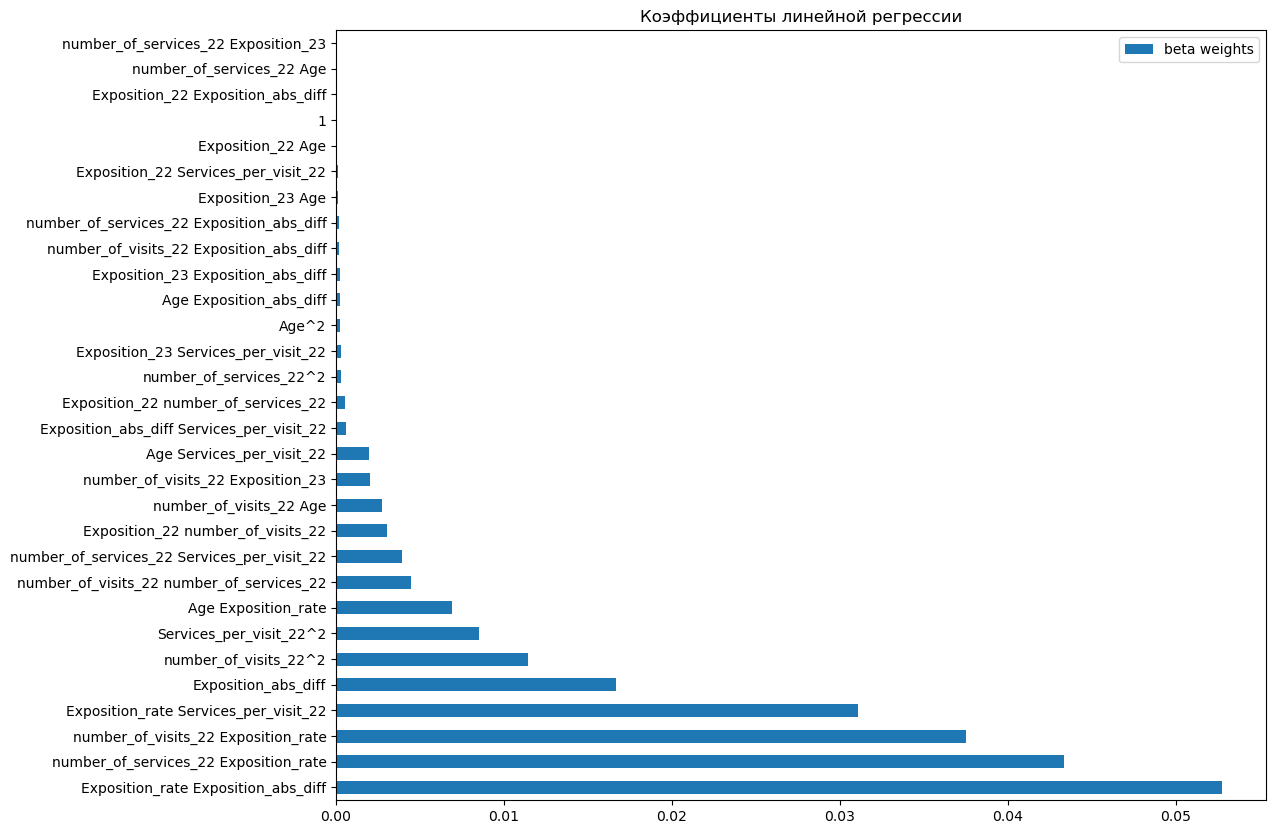

In [35]:
lr_poly_fimportance = pd.DataFrame(np.abs(lr_poly_pipe['lr_poly'].coef_),
                                index=lr_poly_pipe['prep']['poly'].get_feature_names_out().tolist() + \
                                      lr_poly_pipe['prep']['ohe'].get_feature_names_out().tolist(),
                                columns=['beta weights']
                               )
lr_poly_fimportance.sort_values('beta weights', ascending=False).tail(30).plot.barh(figsize=(12, 10),
                                                                                      title='Коэффициенты линейной регрессии');

Меньшее значение модуля коэффициета ${\beta}$ говорит о том, что на определенное изменение целевого признака нужно меньшее значение изменения признака при данном коэффициенте.

Это можно интерпретировать так, что меньшее по модулю значение коэффициента (кроме нуля) стоит при наиболее важных для целевой переменной признаках. Однако, после выявления таких признаков необходимо учесть масштаб их единиц измерения.

**В данном случае** из-за квадратичных значений признаков, полученных умножением друг на друга, при разности их изначальных масштабов их интерпретация затруднена,тем не менее эта модель показывает лучший результат среди моделей линейной регрессии по метрке MSE.

#### Лучшая интерпретируемость

In [36]:
%%time

transformer = ColumnTransformer(
    transformers=[
        ('select_ftrs', ColumnExtractor(cols=num_cols), features_train.columns),
        ('ohe', OneHotEncoder(sparse_output=False), cat_cols),
                 ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
).set_output(transform="pandas")


lr_pipe = Pipeline([
    ('prep', transformer),
    ('lr', LinearRegression())
])



lr_pipe.fit(features_train, target_train)
lr_val_pred = lr_pipe.predict(features_val)
lr_mse = mean_squared_error(lr_val_pred, target_val)
print(f'MSE равен: {lr_mse:.3f}')

MSE равен: 23.162
CPU times: user 661 ms, sys: 96.3 ms, total: 757 ms
Wall time: 652 ms


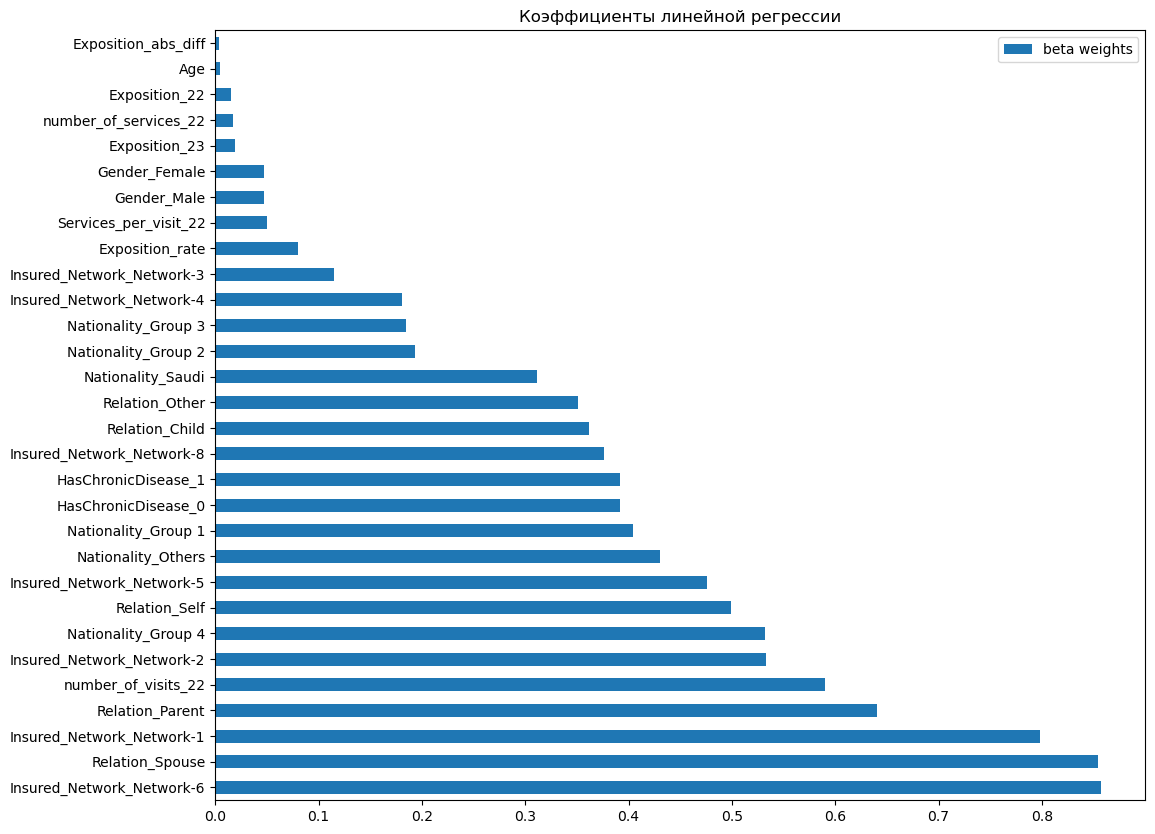

In [37]:
lr_fimportance = pd.DataFrame(np.abs(lr_pipe['lr'].coef_),
                              index=num_cols + \
                              lr_pipe['prep']['ohe'].get_feature_names_out().tolist(),
                              columns=['beta weights']
                             )
lr_fimportance.sort_values('beta weights', ascending=False).tail(30).plot.barh(figsize=(12, 10),
                                                                                      title='Коэффициенты линейной регрессии');

Наиболее важными признаками по критерию абсолютной величины бета-коэффициентов представляются признаки:

In [38]:
lr_fimportance[:10].sort_values('beta weights', ascending=True)

,beta weights
Exposition_abs_diff,0.003972
Age,0.004381
Exposition_22,0.015292
number_of_services_22,0.017341
Exposition_23,0.019220
Services_per_visit_22,0.049649
Exposition_rate,0.080040
Insured_Network_Network-2,0.532927
number_of_visits_22,0.589862
Insured_Network_Network-1,0.798214


### Случайный лес

#### Кросс-валидация

In [40]:
%%time

transformer = ColumnTransformer(
    transformers=[
        ('select_ftrs', ColumnExtractor(cols=num_cols + diags_columns.tolist()), features_train.columns),
        ('ord_enc', OrdinalEncoder(handle_unknown='use_encoded_value', 
                                   unknown_value=-1), cat_cols)
                 ],
    remainder='drop',
    verbose_feature_names_out=False,
    n_jobs=-1
).set_output(transform="pandas")

pipe = Pipeline([
    ('prep', transformer),
    ('rf', RandomForestRegressor())])

rf_param_grid = {
    'rf__n_estimators' : [200, 300],
    'rf__criterion': ['squared_error', 'poisson'],
    'rf__max_features': ['sqrt', 'log2'],
    # 'max_features': [None],
    'rf__min_impurity_decrease': [0, 1.6029131115624923e-11],
}
    

cv = HalvingGridSearchCV(pipe,
                         param_grid=rf_param_grid,
                         scoring='neg_mean_squared_error',
                         cv=3,
                         verbose=1,
                         n_jobs=-1,
                         aggressive_elimination=True,
                         min_resources=1000
)

cv.fit(train_df.drop(tar_col, axis=1), train_df[tar_col]) 

rf_cv_model,  rf_cv_params,  rf_cv_score = cv.best_estimator_, cv.best_params_, cv.best_score_
print_cv_results(rf_cv_params, rf_cv_score)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 4
min_resources_: 1000
max_resources_: 50000
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 16
n_resources: 3000
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 1
n_candidates: 6
n_resources: 9000
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/home/panther/anaconda3/envs/forge/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 2
n_candidates: 2
n_resources: 27000
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Лучшие параметры модели: {'rf__criterion': 'poisson', 'rf__max_features': 'sqrt', 'rf__min_impurity_decrease': 0, 'rf__n_estimators': 300}
(train, CV) лучшее MSE: -27.3672

CPU times: user 2min 31s, sys: 6.03 s, total: 2min 37s
Wall time: 8min 26s


#### Отложенная валидация

In [39]:
%%time

transformer = ColumnTransformer(
    transformers=[
        ('select_ftrs', ColumnExtractor(diags_columns.tolist()), features_train.columns),
        ('poly', PolynomialFeatures(degree=2), num_cols),
        ('orde', OrdinalEncoder(), cat_cols)
                 ],
    remainder='drop',
    verbose_feature_names_out=False,
    n_jobs=-1
).set_output(transform="pandas")

rf_params = {'criterion': 'poisson',
             'max_features': 'sqrt',
             'min_impurity_decrease': 0,
             'n_estimators': 300}

pipe = Pipeline([
    ('prep', transformer),
    ('rf', RandomForestRegressor(random_state=random_state, **rf_params))
])



pipe.fit(features_train, target_train)
rf_val_pred = pipe.predict(features_val)
rf_mse = mean_squared_error(rf_val_pred, target_val)
print(f'MSE равен: {rf_mse:.3f}')

MSE равен: 22.606
CPU times: user 2min 10s, sys: 1.15 s, total: 2min 11s
Wall time: 2min 13s


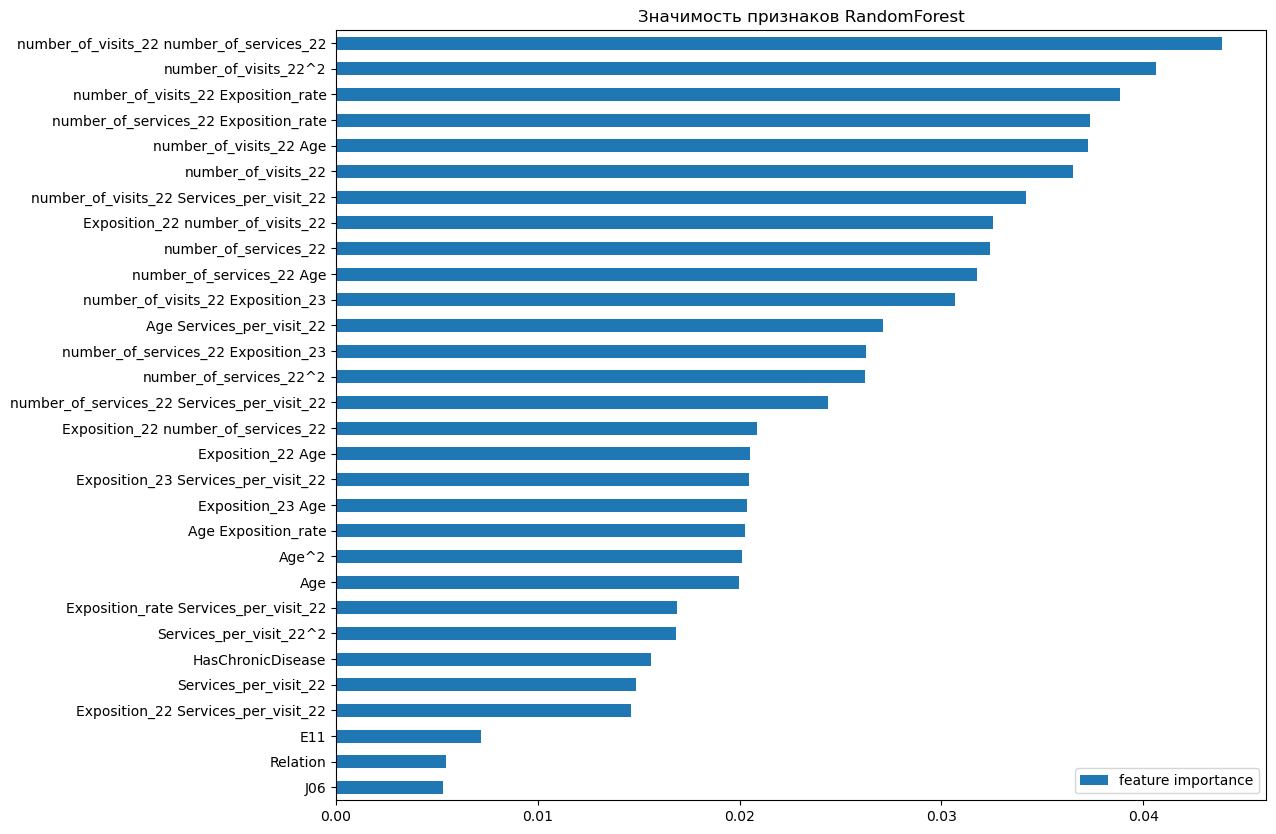

In [40]:
rf_fimportance = pd.DataFrame(pipe['rf'].feature_importances_,
                              index=diags_columns.tolist() + \
                                    pipe.named_steps['prep']['poly'].get_feature_names_out().tolist() + \
                                    pipe.named_steps['prep']['orde'].get_feature_names_out().tolist(),
                              columns=['feature importance'])
rf_fimportance.sort_values('feature importance', ascending=True).tail(30).plot.barh(figsize=(12, 10),
                                                                                      title='Значимость признаков RandomForest');

Так как интерпретируемость важности признаков в случайного леса затруднена, то необходимости сохранять признаки "чистыми" нет, поэтому введены полиномиальные признаки по причине того, что они улучшают итоговую метрику.

Наиболее важными признаками для случайного леса являются:

In [41]:
rf_fimportance.sort_values('feature importance', ascending=False).head(10)

,feature importance
number_of_visits_22 number_of_services_22,0.043896
number_of_visits_22^2,0.040647
number_of_visits_22 Exposition_rate,0.038836
number_of_services_22 Exposition_rate,0.037364
number_of_visits_22 Age,0.037287
number_of_visits_22,0.036504
number_of_visits_22 Services_per_visit_22,0.034189
Exposition_22 number_of_visits_22,0.032543
number_of_services_22,0.032407
number_of_services_22 Age,0.031773


Значимость диагнозов для модели случайного леса:

In [42]:
# Верхние 10 диагнозов отсортированные по значимости для модели LightGBM Regressor
rf_imp_diags_10 = rf_fimportance.loc[diags_columns].sort_values('feature importance', ascending=False)[:10]

rf_imp_diags_10 = pd.merge(rf_imp_diags_10,
                           mkb10.loc[rf_imp_diags_10.index].drop('Код родителя', axis=1),
                           left_index=True, right_index=True, how='outer'
                          ).sort_values('feature importance', ascending=False)
rf_imp_diags_10

,feature importance,Название диагноза
E11,0.007190,Инсулиннезависимый сахарный диабет
J06,0.005284,Острые инфекции верхних дыхательных путей множ...
I10,0.004842,Эссенциальная [первичная] гипертензия
R10,0.004810,Боли в области живота и таза
E78,0.004715,Нарушения обмена липопротеидов и другие липидемии
M25,0.004245,"Другие поражения суставов, не классифицированн..."
K29,0.003998,Гастрит и дуоденит
J00,0.003932,Острый назофарингит (насморк)
J02,0.003802,Острый фарингит
M54,0.003745,Дорсалгия


### Градиентный бустинг - LightGBM

#### Кросс-валидация

In [33]:
%%time

transformer = ColumnTransformer(
    transformers=[
        ('select_ftrs', ColumnExtractor(diags_columns.tolist()), features_train.columns),
        ('poly', PolynomialFeatures(degree=2), num_cols),
        ('ord_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
                 ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
).set_output(transform="pandas")

pipe = Pipeline([
    ('prep', transformer),
    ('lgbm', LGBMRegressor(random_state=random_state, verbose=-1))])

space = {
    'lgbm__n_estimators': Integer(50, 2000, prior='log-uniform', base=10),
    'lgbm__num_leaves': Integer(2, 60, prior='log-uniform', base=10),
    'lgbm__min_child_samples': Integer(2, 100, prior='log-uniform', base=10),
    'lgbm__learning_rate': Real(1e-16, 1, prior='log-uniform', base=10),
    'lgbm__reg_alpha': Real(0, 10000, prior='uniform', base=10),
    'lgbm__reg_lambda': Real(0, 10000, prior='uniform', base=10)
}


cv = BayesSearchCV(pipe,
                   space,
                   n_iter=300,
                   scoring='neg_mean_squared_error',
                   random_state=random_state,
                   cv=5,
                   n_jobs=-1
                  )

cv.fit(train_df.drop(tar_col, axis=1), train_df[tar_col]) 

lgbm_cv_model,  lgbm_cv_params,  lgbm_cv_score = cv.best_estimator_, cv.best_params_, cv.best_score_
print_cv_results(lgbm_cv_params, lgbm_cv_score)


Лучшие параметры модели: OrderedDict({'lgbm__learning_rate': 0.40920968878167613, 'lgbm__min_child_samples': 5, 'lgbm__n_estimators': 1476, 'lgbm__num_leaves': 3, 'lgbm__reg_alpha': 0.0, 'lgbm__reg_lambda': 6136.76200289499})
(train, CV) лучшее MSE: -23.9107

CPU times: user 2h 8min 53s, sys: 3min 30s, total: 2h 12min 24s
Wall time: 9h 38min 27s


#### Отложенная валидация

In [43]:
transformer = ColumnTransformer(
    transformers=[
        ('select_ftrs', ColumnExtractor(cols=diags_columns.tolist()), features_train.columns),
        ('poly', PolynomialFeatures(degree=2), num_cols),
        ('orde', OrdinalEncoder(), cat_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
).set_output(transform="pandas")

lgbm_params = {
    'verbose': -1,
    'learning_rate': 0.10435908167710195,
    'min_child_samples': 2,
    'n_estimators': 2000,
    'num_leaves': 7,
    'reg_alpha': 0.0,
    'reg_lambda': 5102.2181107006245
    # 'learning_rate': 0.40920968878167613,
    # 'min_child_samples': 5,
    # 'n_estimators': 1476,
    # 'num_leaves': 3,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 6136.76200289499
}

lgbm_pipe = Pipeline([
    ('prep', transformer),
    ('lgbm', LGBMRegressor(random_state=random_state, **lgbm_params))])



lgbm_pipe.fit(features_train, target_train)
lgbm_val_pred = lgbm_pipe.predict(features_val)
lgbm_mse = mean_squared_error(lgbm_val_pred, target_val)
print(f'MSE равен: {lgbm_mse:.3f}')

MSE равен: 21.800


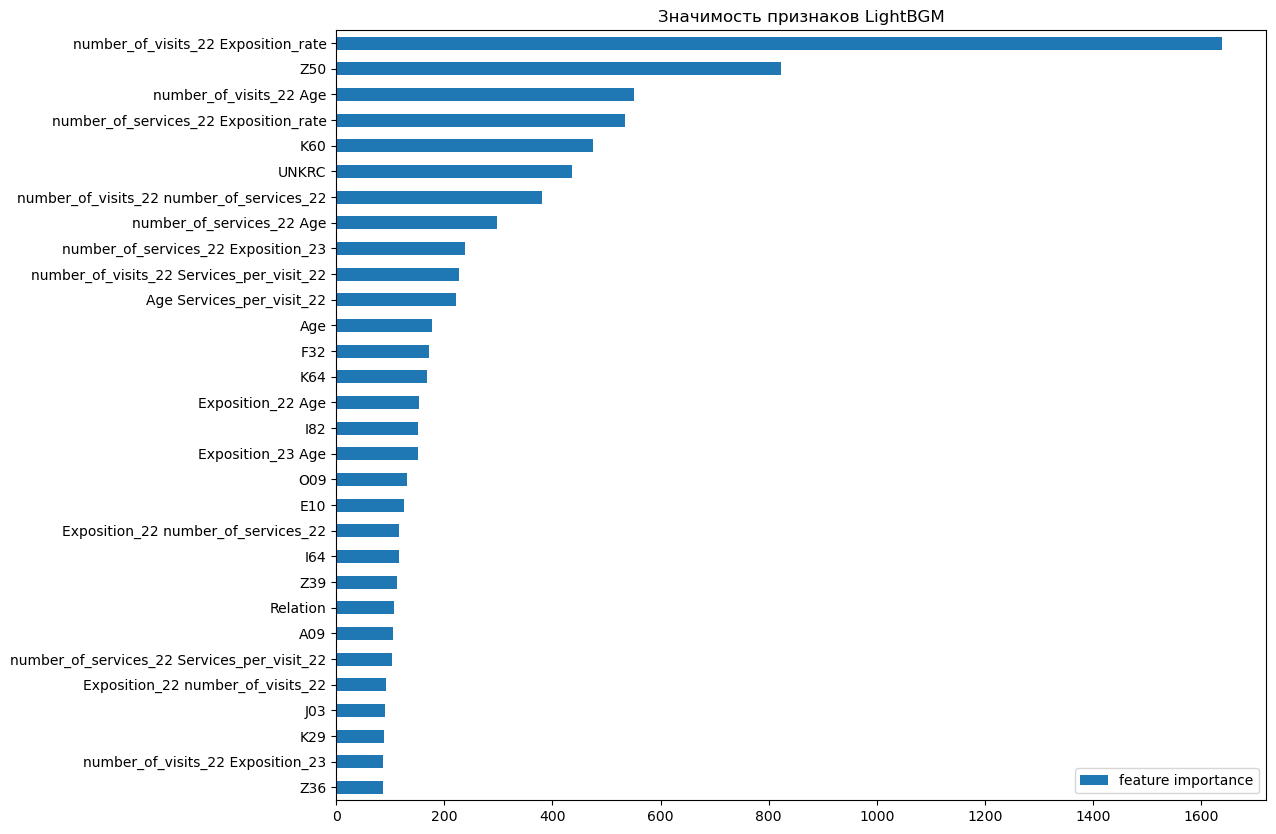

In [44]:
lgbm_fimportance = pd.DataFrame(lgbm_pipe['lgbm'].feature_importances_,
                                index=diags_columns.tolist() + \
                                      lgbm_pipe.named_steps['prep']['poly'].get_feature_names_out().tolist() + \
                                      lgbm_pipe.named_steps['prep']['orde'].get_feature_names_out().tolist(),
                                columns=['feature importance']
                               )
lgbm_fimportance.sort_values('feature importance', ascending=True).tail(30).plot.barh(figsize=(12, 10),
                                                                                      title='Значимость признаков LightBGM');

Самые значимые признаки: 

In [45]:
lgbm_fimportance.sort_values('feature importance', ascending=False).head(10)

,feature importance
number_of_visits_22 Exposition_rate,1638
Z50,822
number_of_visits_22 Age,551
number_of_services_22 Exposition_rate,535
K60,476
UNKRC,437
number_of_visits_22 number_of_services_22,381
number_of_services_22 Age,297
number_of_services_22 Exposition_23,238
number_of_visits_22 Services_per_visit_22,228


Значимые для модели диагнозы:

In [46]:
# Верхние 10 диагнозов отсортированные по значимости для модели LightGBM Regressor
lgbm_imp_diags_10 = lgbm_fimportance.loc[diags_columns].sort_values('feature importance', ascending=False)[:10]

lgbm_imp_diags_10 = pd.merge(lgbm_imp_diags_10,
                             mkb10.loc[lgbm_imp_diags_10.drop(['UNKRC', 'K64', 'O09']).index].drop('Код родителя', axis=1),
                             left_index=True, right_index=True, how='outer'
                            ).sort_values('feature importance', ascending=False)

lgbm_imp_diags_10.loc['UNKRC', 'Название диагноза'] = 'Unknown Race\Раса не определена'
lgbm_imp_diags_10.loc['O09', 'Название диагноза'] = 'Срок (продолжительность) беременности'
lgbm_imp_diags_10.loc['K64', 'Название диагноза'] = 'Геморрой и перианальный венозный тромбоз'

lgbm_imp_diags_10

,feature importance,Название диагноза
Z50,822,"Помощь, включающая использование реабилитацион..."
K60,476,Трещина и свищ области заднего прохода и прямо...
UNKRC,437,Unknown Race\Раса не определена
F32,172,Депрессивный эпизод
K64,168,Геморрой и перианальный венозный тромбоз
I82,152,Эмболия и тромбоз других вен
O09,132,Срок (продолжительность) беременности
E10,125,Инсулинзависимый сахарный диабет
I64,116,"Инсульт, не уточненный как кровоизлияние или и..."
Z39,112,Послеродовая помощь и обследование


В русскоязычном классификаторе почему-то нет кодов `O09` и `K64`.
 - `UNKRC` в англоязычной кодификации отражает состояние `Unknown Race\Раса не определена`

В других источниках коды болезеней расшифрованы как:
 - `O09` Срок (продолжительность) беременности
 - `K64` Геморрой и перианальный венозный тромбоз 

### Выводы

- На обработанных данных были обучены и проверены модели линейной регрессии, случайного леса градиентного бустинга (LightGBM)
- Для моделей случайного леса и градиентного бустинга осуществлен подбор оптимальных гиперпараметров
- В результате были выявлены признаки, наиболее важные для прогнозных моделей
- Получены итоговые показатели моделей на валидационной выборке, обученных на 90% обучающей выборки:

In [47]:
val_results = pd.DataFrame({'Модель:':['baseline DummyRegressor (val)',
                                       'Логистическая регрессия (val)',
                                       'Случайный лес (val)',
                                       'Градиентный бустинг (val)'],
             'MSE':[round(i, 3) for i in [dr_mse, lr_mse, rf_mse, lgbm_mse]]}).set_index('Модель:').T
val_results

Модель:,baseline DummyRegressor (val),Логистическая регрессия (val),Случайный лес (val),Градиентный бустинг (val)
MSE,44.829,23.162,22.606,21.8


По результатам обучения моделей выявлена модель с наименьшим значением среднеквадратичной ошибки, это модель **градиентного бустинга в реализации LightGBM**. Она показала результат в 21.8 дней$^2$ по метрике MSE на валидационной выборке размера 10%.

Результатаы модели LightGBM были получены со следующими гиперпараметрами:

In [48]:
lgbm_params

{'verbose': -1,
 'learning_rate': 0.10435908167710195,
 'min_child_samples': 2,
 'n_estimators': 2000,
 'num_leaves': 7,
 'reg_alpha': 0.0,
 'reg_lambda': 5102.2181107006245}

## Обучение и тестирование выбранной модели

### Обучение выбранной модели на полной выборке:

In [49]:
final_model = lgbm_pipe.fit(train_df.drop(tar_col, axis=1), train_df[tar_col])

### Инференс модели на тестовых данных:

In [50]:
test_target = final_model.predict(test_df)

Предсказанные показатели целевого признака на тестовой выборке (не округленные):

In [51]:
nov_23_pred = pd.DataFrame(test_target, index=test.index, columns=['number_of_visits_23'])
nov_23_pred

,number_of_visits_23
0,1.962586
1,5.047905
2,6.049095
3,7.173607
4,5.387641
...,...
9995,7.701442
9996,10.519791
9997,3.021367
9998,2.047983


Округленные:

In [52]:
nov_23_rounded_pred = pd.DataFrame(test_target.round().astype('int16'), index=test.index, columns=['number_of_visits_23'])
nov_23_rounded_pred

,number_of_visits_23
0,2
1,5
2,6
3,7
4,5
...,...
9995,8
9996,11
9997,3
9998,2


In [58]:
# nov_23_pred.to_csv(dataset_path+'nov_23_test_results.csv')
# nov_23_rounded_pred.to_csv(dataset_path+'nov_23_rounded_test_results.csv')

## Общий вывод

В ходе данного исследования решалась задача прогноза по данным страховых компаний срока пользования застрахованными пациентами услуг клиники `number_of_visits_23`

На предоставленных данных о пациентах следовало натренировать модели регрессии, предсказывающие количество дней, в которые пациент посещал клинику.

Данные представляли из себя набор признаков, характеризующие каждого пациента: личные физиологические признаки, диагнозы пациента, а также особенности его страховки.

В ходе решения данной задачи данные были подготовлены и проанализированы:
- диагнозы были переведены в признаки датафрейма
- устранены пробелы в данных
- сформированы новые признаки на основе существующих

Также на этих данных были обучены и проверены 3 модели машинного обучения:

- Логистическая регрессия
- Случайный лес
- LightGBM реализация градиентного бустинга

В ходе исследования было обнаружено, что лучше всего с задачей справляется модель градиентного бустинга

В результате получена модель градиентного бустинга, предсказывающая признак `number_of_visits_23` с отклоенением 21.8 дней$^2$ по метрике MSE

## Отчет по решению

### Постановка задачи и проблемы реализации 

На основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год. 
Для оценки качества модели применяется метрика MSE.

Работа в рамках данного проекта была проделана согласно плану:

   - Загрузить и подготовить данные
   - Провести исследовательский анализ данных
   - Предобработать данные
   - Обучить разне модели регресси и выполнить подбор гиперпараметров
       - Предоставить Baseline модель для сравнения
       - Выбрать модели регрессии для проекта
       - Осуществить подбор гимерпараметров моделей 
       - Отобрать модель регрессии и с наименьшим значением MSE
   - Провести финальное обучение и сформировать результат на тестовой выборке
     
Для выполнения задачи нужно было выполнить следующие шаги:
 - Описать и проанализировать данные
 - Обработать данные, очистив их от аномалий и выбросов и подготовить их для моделирования, выделив необходимые признаки
 - Провести обучение моделей машинного обучения на подготовленных данных и протестировать выбранную модель на предмет достижения поставленной цели по качеству предсказания
 
Все пункты данного плана были выполнены. В ходе выполнения проекта возникли трудности с идентификацией диагнозов а также с их представлением в качестве признаков для обучающихся моделей. Для решения этих проблем были загружены дополнительные данные классификатора МКБ-10, а также проведена работа по переводу списков диагнозов, ассоциированных с каждым застрахованным клиентом, в признаковое пространство. 

### Описание и анализ данных

**Описание данных:**

Доступны 2 выборки: 

- train - выборка для обучения и валидации , 50 тыс. застрахованных с проставленными значениями target.
- holdout - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения target скрыты.

Изначальные признаки в доступных данных:
   
   - `Insured_PIN` - уникальный ид застрахованного лица
   - `Insured_Network` - Идентификатор сети клиник доступной для застрахованного. `Network - 1` - клиники с наивысшим уровнем сервиса, `Network - 8` - клиники с самым базовым уровнем сервиса.
   - `Nationality` - национальность застрахованного.
   - `Gender` - пол застрахованного
   - `Relation` - в качестве кого застраховано данное лицо. `self` - работник организации, которая оформляет страховку, `child` - ребенок застрахованного и т.д.
   - `DoB` - дата рождения застрахованного
   - `Diagnoses` - все диагнозы застрахованного за 2022 год
   - `HasChronicDisease` - флаг хронического пациента
   - `Exposition_22` - количество дней в 2022 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год
   - `number_of_visits_22` - количество дней в 2022 году в которые застрахованный посещал клинику для получения медицинской помощи
   - `number_of_services_22` - количество оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.)
   - `Exposition_23` - количество дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год
   - **Target -** `number_of_visits_23` - количество дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи. **Этот показатель требуется предсказать.**

В данных имелись пропуски и непригодные признаки:

- Обнаружены пропуски в признаках `DoB` и `Diagnoses`
- Были обнаружен непригодный признак `Insured_PIN`


### Работа с признаками и предобработка данных

Для целей предсказания признака `number_of_visits_23` из данных были отобраны и созданы следующие признаки:
  - Отобранные:
     	Все, кроме признаков `DoB` (преобразован в `Age`), `Insured_PIN` (Удален) и `Diagnoses` (преобразован в матрицу признаков)
  - Созданные:
      `Exposition_rate`, `Exposition_abs_diff`, `Services_per_visit_22`, а также матрица признаков, преобразованная из колонки `Diagnoses`
     
Итоговый набор признаков был сведен в датафреймы `train_df`, `test_df`

Корреляционный анализ показал cущественную корреляцию между целевым признаком и признаками `number_od_visits_22`, `number_of_services_22`. Абсолютно скоррелированные признаки отсуствуют, то есть между всеми признаками нет прямой линейной зависимости.

Пробелы в данных были обработаны:
  - пробелы в признаках `DoB` и `Diagnoses` были заполнены. В первом случае медианным возрастом (после преобразования `DoB` в `Age`), во втором случае - заглушками с отрицательнымм значением (-1) подкатегории диагноза, либо же значением 9 (неуточненный диагноз), когда сам код болезни присутствовал, а подкатегория диагноза - нет. 
  
Также была проведена оптимизация типов данных с целью уменьшения потребления памяти\процессорного времени (через применение функции `downcast_df()` ).

После предобработки набор данных из файла `train_df` был разделен на обучающую и тестовую выборки. 

### Характеристика выбранной модели

Для обучения были выбраны 4 регрессионные модели:
- Константная baseline модель (DummyRegressor, sklearn), предсказывающая целевой признак по среднему значению;
- Линейная регрессия (LinearRegressor, sklearn);
- Случайный лес (RandomForest, sklearn);
- Градиентный бустинг (LGBMRegressor, lightgbm)

По результатам проведенного методом кросс-валидации обучения была отобрана регрессионная модель LightGBM, показавшая такие результаты:


In [54]:
val_results['Градиентный бустинг (val)']

MSE    21.8
Name: Градиентный бустинг (val), dtype: float64

Этот результат получен при обучении модели LGBMRegressor с параметрами:

In [55]:
lgbm_params

{'verbose': -1,
 'learning_rate': 0.10435908167710195,
 'min_child_samples': 2,
 'n_estimators': 2000,
 'num_leaves': 7,
 'reg_alpha': 0.0,
 'reg_lambda': 5102.2181107006245}

Наиболее важными признаками для этой модели стали:

In [56]:
lgbm_fimportance.sort_values('feature importance', ascending=False).head(10)

,feature importance
number_of_visits_22 Exposition_rate,1638
Z50,822
number_of_visits_22 Age,551
number_of_services_22 Exposition_rate,535
K60,476
UNKRC,437
number_of_visits_22 number_of_services_22,381
number_of_services_22 Age,297
number_of_services_22 Exposition_23,238
number_of_visits_22 Services_per_visit_22,228


Наиболее важными диагнозами:

In [57]:
lgbm_imp_diags_10

,feature importance,Название диагноза
Z50,822,"Помощь, включающая использование реабилитацион..."
K60,476,Трещина и свищ области заднего прохода и прямо...
UNKRC,437,Unknown Race\Раса не определена
F32,172,Депрессивный эпизод
K64,168,Геморрой и перианальный венозный тромбоз
I82,152,Эмболия и тромбоз других вен
O09,132,Срок (продолжительность) беременности
E10,125,Инсулинзависимый сахарный диабет
I64,116,"Инсульт, не уточненный как кровоизлияние или и..."
Z39,112,Послеродовая помощь и обследование
